In [5]:
pip install resampy

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
print(os.getcwd())

/content


In [8]:
data_path = '/content/drive/MyDrive/DST'
print((data_path))

/content/drive/MyDrive/DST


In [9]:
filelist = (data_path)

for filename in filelist:
  print(filename)

/
c
o
n
t
e
n
t
/
d
r
i
v
e
/
M
y
D
r
i
v
e
/
D
S
T


In [10]:
%matplotlib inline

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

In [11]:
from pickle import dump
from pickle import load

In [12]:
train_data = data_path+"/train"
(train_data)

'/content/drive/MyDrive/DST/train'

In [13]:
val_data = data_path+"/val"
(val_data)

'/content/drive/MyDrive/DST/val'

In [14]:
test_data = data_path+"/test"
(test_data)

'/content/drive/MyDrive/DST/test'

In [15]:
normal_train = train_data+"/n_*.wav"
abnormal_train = train_data+"/a_*.wav"

In [16]:
normal_train

'/content/drive/MyDrive/DST/train/n_*.wav'

In [17]:
normal_val = val_data+"/n_*.wav"
abnormal_val = val_data+"/a_*.wav"

In [18]:
import librosa
import librosa.display

In [19]:
import glob

normal_train_signals = [
    librosa.load(p)[0] for p in glob.glob(normal_train)
]

abnormal_train_signals = [
    librosa.load(p)[0] for p in glob.glob(abnormal_train)
]

normal_val_signals = [
    librosa.load(p)[0] for p in glob.glob(normal_val)
]

abnormal_val_signals = [
    librosa.load(p)[0] for p in glob.glob(abnormal_val)
]

In [20]:
print("Shape of normal_train_signals:", np.array(normal_train_signals, dtype=object).shape)
print("Shape of abnormal_train_signals:", np.array(abnormal_train_signals, dtype=object).shape)
print("Shape of normal_val_signals:", np.array(normal_val_signals, dtype=object).shape)
print("Shape of abnormal_val_signals:", np.array(abnormal_val_signals, dtype=object).shape)

Shape of normal_train_signals: (64, 110250)
Shape of abnormal_train_signals: (175, 110250)
Shape of normal_val_signals: (119, 110250)
Shape of abnormal_val_signals: (47, 110250)


In [21]:
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [22]:
datasetFile = 'coffee_train.pkl'
save_dataset([normal_train_signals, abnormal_train_signals], datasetFile)

Saved: coffee_train.pkl


In [23]:
datasetFile_val = 'coffee_val.pkl'
save_dataset([normal_val_signals, abnormal_val_signals], datasetFile_val)

Saved: coffee_val.pkl


In [24]:
def load_dataset(filename):
    return load(open(filename, 'rb'))

[normal_train_signals, abnormal_train_signals] = load_dataset(datasetFile)

In [25]:
len(normal_train_signals), len(abnormal_train_signals)

(64, 175)

In [26]:
[normal_val_signals, abnormal_val_signals] = load_dataset(datasetFile_val)

In [27]:
len(normal_val_signals), len(abnormal_val_signals)

(119, 47)

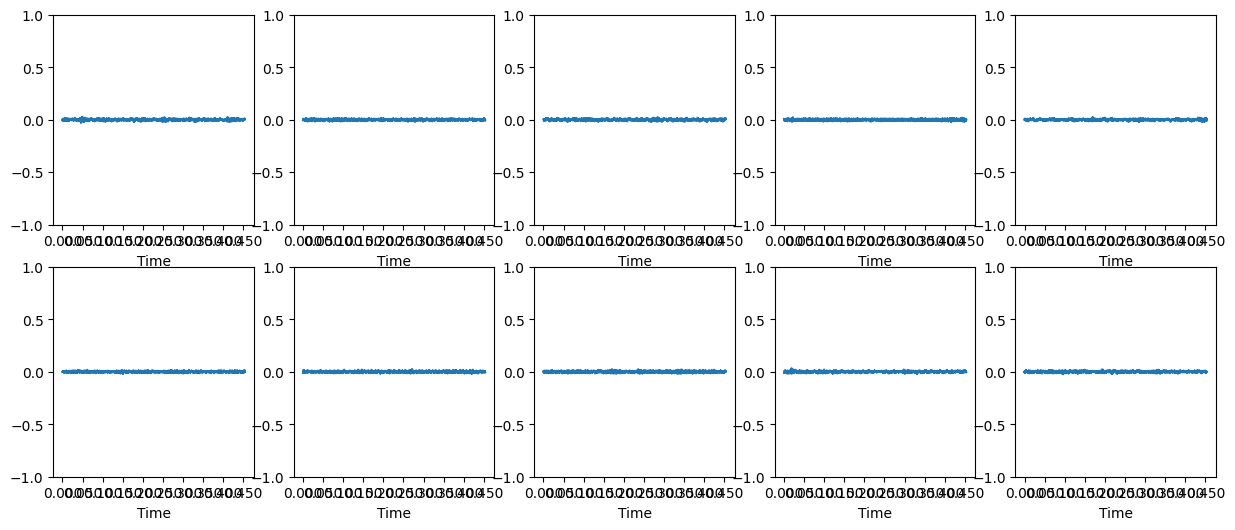

In [28]:
plt.figure(figsize=(15, 6))
for i, x in enumerate(normal_train_signals[:10]):
    plt.subplot(2, 5, i+1)
    librosa.display.waveshow(x[:10000])
    plt.ylim(-1, 1)

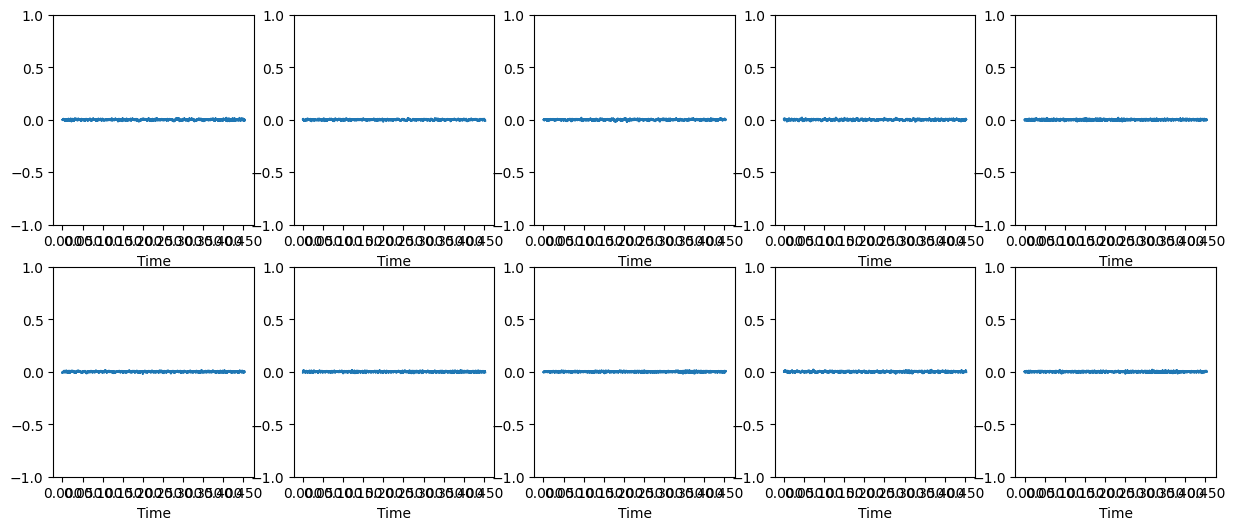

In [29]:
plt.figure(figsize=(15, 6))
for i, x in enumerate(abnormal_train_signals[:10]):
    plt.subplot(2, 5, i+1)
    librosa.display.waveshow(x[:10000])
    plt.ylim(-1, 1)

In [30]:
def extract_features(signal):
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(y=signal)[0, 0],
    ]

In [31]:
normal_train_features = np.array([extract_features(x) for x in normal_train_signals])
abnormal_train_features = np.array([extract_features(x) for x in abnormal_train_signals])

In [32]:
normal_val_features = np.array([extract_features(x) for x in normal_val_signals])
abnormal_val_features = np.array([extract_features(x) for x in abnormal_val_signals])

In [33]:
print(normal_train_features.shape)
print(abnormal_train_features.shape)
print(normal_val_features.shape)
print(abnormal_val_features.shape)

(64, 2)
(175, 2)
(119, 2)
(47, 2)


In [34]:
print(normal_train_features[10])
print(abnormal_train_features[10])
print(normal_val_features[10])
print(abnormal_val_features[10])

[4.58984375e-02 1.87863168e+03]
[2.34375000e-02 1.28166478e+03]
[3.71093750e-02 1.85925683e+03]
[3.02734375e-02 1.48562489e+03]


Text(0, 0.5, 'Count')

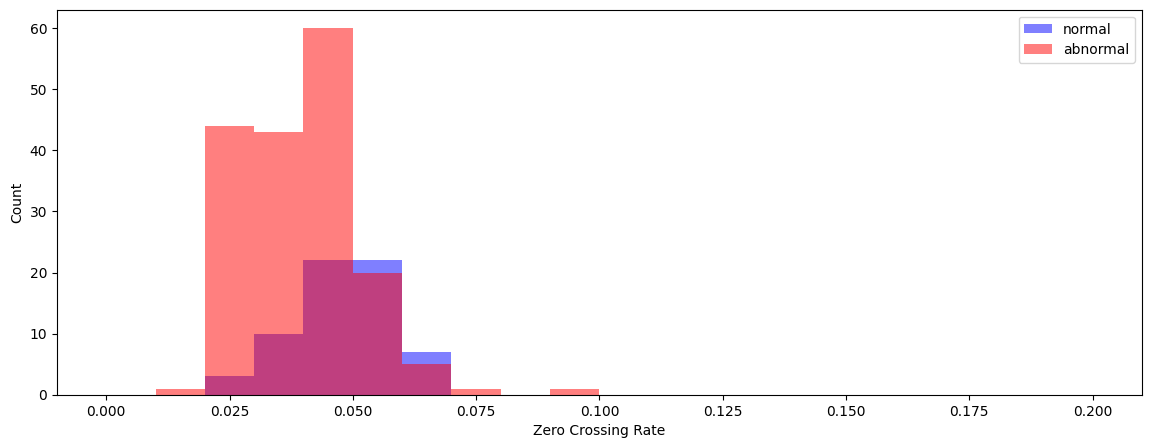

In [35]:
plt.figure(figsize=(14, 5))
plt.hist(normal_train_features[:,0], color='b', range=(0, 0.2), alpha=0.5, bins=20)
plt.hist(abnormal_train_features[:,0], color='r', range=(0, 0.2), alpha=0.5, bins=20)
plt.legend(('normal', 'abnormal'))
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

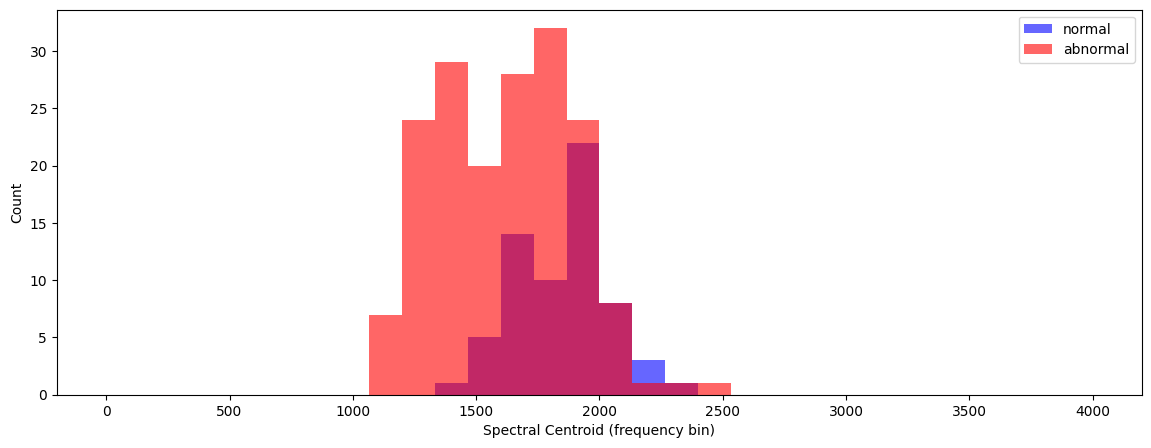

In [36]:
plt.figure(figsize=(14, 5))
plt.hist(normal_train_features[:,1], color='b', range=(0, 4000), bins=30, alpha=0.6)
plt.hist(abnormal_train_features[:,1], color='r', range=(0, 4000), bins=30, alpha=0.6)
plt.legend(('normal', 'abnormal'))
plt.xlabel('Spectral Centroid (frequency bin)')
plt.ylabel('Count')

In [37]:
feature_train_table = np.vstack((normal_train_features, abnormal_train_features))
print(feature_train_table.shape)

(239, 2)


In [38]:
feature_val_table = np.vstack((normal_val_features, abnormal_val_features))
print(feature_val_table.shape)

(166, 2)


In [39]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
training_features = scaler.fit_transform(feature_train_table)
print(training_features.min(axis=0))
print(training_features.max(axis=0))

[-1. -1.]
[1. 1.]


In [40]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
val_features = scaler.fit_transform(feature_val_table)
print(val_features.min(axis=0))
print(val_features.max(axis=0))

[-1. -1.]
[1. 1.]


Text(0, 0.5, 'Spectral Centroid')

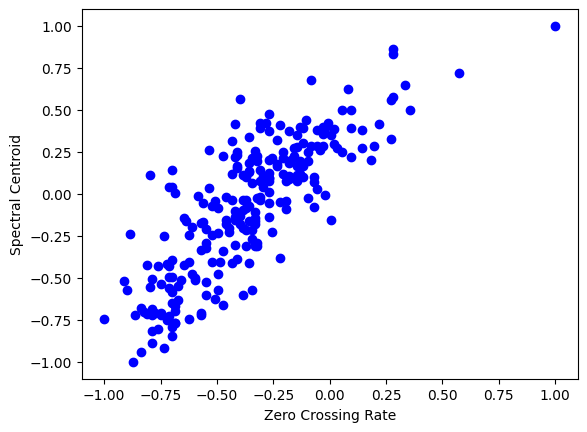

In [41]:
plt.scatter(training_features[:489,0], training_features[:489,1], c='b')
plt.scatter(training_features[489:,0], training_features[489:,1], c='r')
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Spectral Centroid')

In [42]:
y_train_total = [0 for i in range(489)] + [1 for i in range(175)]
y_val_total = [0 for i in range(119)] + [1 for i in range(47)]

In [43]:
y_train_encoded = to_categorical(y_train_total)
y_val_encoded = to_categorical(y_val_total)

In [44]:
y_train_encoded[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [45]:
x_train = training_features
y_train = y_train_encoded
x_val = val_features
y_val = y_val_encoded

In [46]:
x_train.shape, y_train.shape

((239, 2), (664, 2))

In [47]:
x_val.shape, y_val.shape

((166, 2), (166, 2))

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

In [49]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(2,)))
    model.add(Dense(8))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    return model

In [50]:
model = create_model()
model.summary()
adam_optim = Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optim, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42 (168.00 B)

 Trainable params: 42 (168.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
print(x_train.shape)
print(y_train.shape)

(239, 2)
(664, 2)


In [52]:
min_len = min(len(x_train), len(y_train))
x_train = x_train[:min_len]
y_train = y_train[:min_len]

In [53]:
his = model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=10,
    verbose=1,
    validation_data = (x_val, y_val)
)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1514 - loss: 0.8143 - val_accuracy: 0.3133 - val_loss: 0.7229
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4264 - loss: 0.7239 - val_accuracy: 0.5723 - val_loss: 0.6892
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7234 - loss: 0.6599 - val_accuracy: 0.6988 - val_loss: 0.6631
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8531 - loss: 0.5970 - val_accuracy: 0.7169 - val_loss: 0.6440
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8953 - loss: 0.5520 - val_accuracy: 0.7169 - val_loss: 0.6303
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9944 - loss: 0.4734 - val_accuracy: 0.7169 - val_loss: 0.6210
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9818 - loss: 0.4388 - val_accuracy: 0.7169 - val_loss: 0.6150
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9975 - loss: 0.4069 - val_accuracy: 0.

In [54]:
import plotly
import plotly.graph_objs as go

In [55]:
h1 = go.Scatter(y=his.history['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his.history['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title='', range=[0, 1]))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [56]:
h1 = go.Scatter(y=his.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title='',range=[0, 1]))
fig2 = go.Figure(data = data, layout=layout1)
fig2.show()

# **CNN Model**

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [58]:
file_name = '/content/drive/MyDrive/DST/train/a_00000004_5000.wav'
audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

print(audio.shape, sample_rate)

mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)

(110250,) 22050
(40, 216)


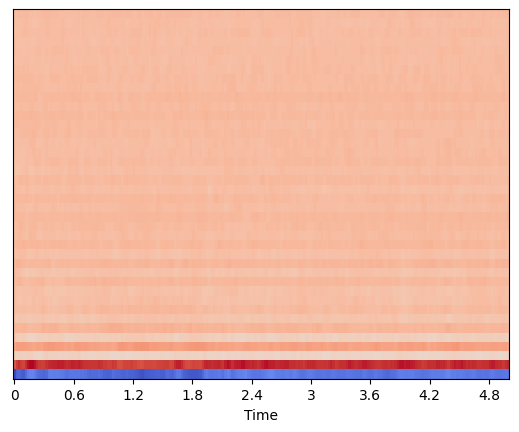

In [59]:
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

In [60]:
max_pad_len = 100

def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, max(0, pad_width))), mode='constant')
    return mfccs

In [61]:
normal_train_features = []
for file_name in glob.glob(normal_train):
    data = extract_features(file_name)
    normal_train_features.append(data)

abnormal_train_features = []
for file_name in glob.glob(abnormal_train):
    data = extract_features(file_name)
    abnormal_train_features.append(data)

normal_val_features = []
for file_name in glob.glob(normal_val):
    data = extract_features(file_name)
    normal_val_features.append(data)

abnormal_val_features = []
for file_name in glob.glob(abnormal_val):
    data = extract_features(file_name)
    abnormal_val_features.append(data)

In [62]:
normal_train_features[0].shape

(40, 216)

In [63]:
feature_train_table = np.vstack((normal_train_features, abnormal_train_features))
print(feature_train_table.shape)

(239, 40, 216)


In [64]:
feature_train_table = feature_train_table.reshape(feature_train_table.shape[0], feature_train_table.shape[1], feature_train_table.shape[2], 1)
print(feature_train_table.shape)

(239, 40, 216, 1)


In [65]:
y_train_encoded[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [66]:
feature_val_table = np.vstack((normal_val_features, abnormal_val_features))

In [67]:
feature_val_table = feature_val_table.reshape(feature_val_table.shape[0], feature_val_table.shape[1], feature_val_table.shape[2], 1)
print(feature_val_table.shape)

(166, 40, 216, 1)


In [68]:
x_train = feature_train_table
x_val = feature_val_table
y_train = y_train_encoded
y_val = y_val_encoded

In [69]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((239, 40, 216, 1), (166, 40, 216, 1), (664, 2), (166, 2))

In [70]:
num_rows = 40
num_columns = 216
num_channels = 1
num_batch_size = 64
epochs = 50

In [71]:
model = Sequential()
model.add(Input(shape=(num_rows, num_columns, num_channels)))
model.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='softmax'))

In [72]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [74]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (239, 40, 216, 1)
y_train: (664, 2)
x_val: (166, 40, 216, 1)
y_val: (166, 2)


In [75]:
min_len_train = min(len(x_train), len(y_train))
x_train = x_train[:min_len_train]
y_train = y_train[:min_len_train]

min_len_val = min(len(x_val), len(y_val))
x_val = x_val[:min_len_val]
y_val = y_val[:min_len_val]

In [76]:
his = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1, callbacks=[checkpoint])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4747 - loss: 5.7810      
Epoch 1: val_loss improved from inf to 11.24960, saving model to best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5262 - loss: 5.2143 - val_accuracy: 0.7169 - val_loss: 11.2496
Epoch 2/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2: val_loss did not improve from 11.24960
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.7169 - val_loss: 17.2410
Epoch 3/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3: val_loss did not improve from 11.24960
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.7169 - val_loss: 21.1720
Epoch 4/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4: val_loss did not improve from 11.24960
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0000e+0

In [77]:
h1 = go.Scatter(y=his.history['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his.history['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [78]:
h1 = go.Scatter(y=his.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig2 = go.Figure(data = data, layout=layout1)
fig2.show()

In [79]:
from tensorflow import keras

model = keras.models.load_model("/content/best_model.keras")

In [80]:
train_res = model.evaluate(x_train, y_train, verbose=0, return_dict=True)
val_res   = model.evaluate(x_val,   y_val,   verbose=0, return_dict=True)

acc_key = next(k for k in train_res.keys() if k in
               ('accuracy', 'binary_accuracy', 'categorical_accuracy',
                'sparse_categorical_accuracy'))

print(f"Training  - loss: {train_res['loss']:.4f}, acc: {train_res[acc_key]:.4f}")
print(f"Validation- loss: {val_res['loss']:.4f}, acc: {val_res[acc_key]:.4f}")


Training  - loss: 0.0000, acc: 1.0000
Validation- loss: 11.2496, acc: 0.7169


In [81]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [82]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[119   0]
 [ 47   0]]


In [83]:
report = classification_report(y_true_classes, y_pred_classes, target_names=['normal', 'abnormal'],digits=4)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      normal     0.7169    1.0000    0.8351       119
    abnormal     0.0000    0.0000    0.0000        47

    accuracy                         0.7169       166
   macro avg     0.3584    0.5000    0.4175       166
weighted avg     0.5139    0.7169    0.5986       166



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



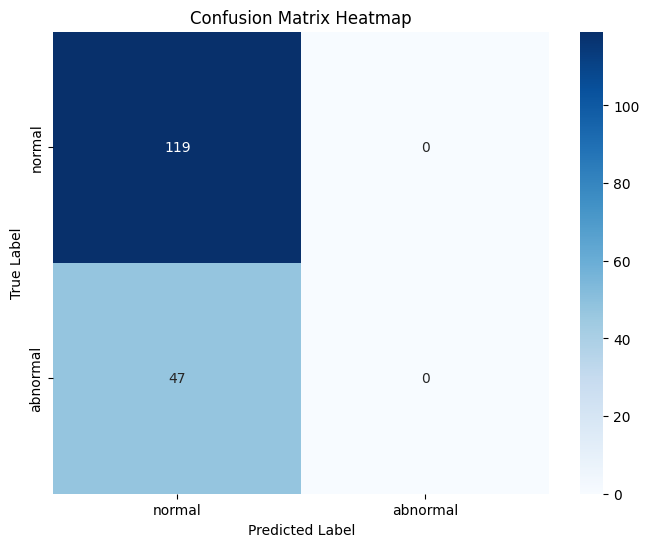

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

**Lab week8**



In [85]:
file_name = '/content/drive/MyDrive/DST/test/a_00000011_5000.wav'
audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

print(audio.shape, sample_rate)

mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)

(110250,) 22050
(40, 216)


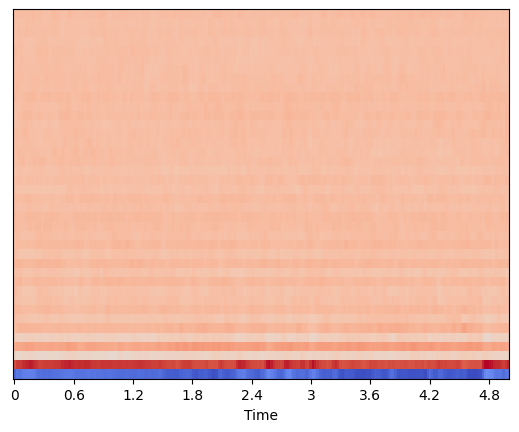

In [86]:
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

In [87]:
max_pad_len = 100

def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, max(0, pad_width))), mode='constant')
    return mfccs

In [88]:
normal_train_features = []
for file_name in glob.glob(normal_train):
    data = extract_features(file_name)
    normal_train_features.append(data)

abnormal_train_features = []
for file_name in glob.glob(abnormal_train):
    data = extract_features(file_name)
    abnormal_train_features.append(data)

normal_val_features = []
for file_name in glob.glob(normal_val):
    data = extract_features(file_name)
    normal_val_features.append(data)

abnormal_val_features = []
for file_name in glob.glob(abnormal_val):
    data = extract_features(file_name)
    abnormal_val_features.append(data)

In [89]:
normal_train_features[0].shape

(40, 216)

In [90]:
feature_train_table = np.vstack((normal_train_features, abnormal_train_features))
print(feature_train_table.shape)

(239, 40, 216)


In [91]:
feature_train_table = feature_train_table.reshape(feature_train_table.shape[0], feature_train_table.shape[1], feature_train_table.shape[2], 1)
print(feature_train_table.shape)

(239, 40, 216, 1)


In [92]:
y_train_encoded[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [93]:
feature_val_table = np.vstack((normal_val_features, abnormal_val_features))

In [94]:
feature_val_table = feature_val_table.reshape(feature_val_table.shape[0], feature_val_table.shape[1], feature_val_table.shape[2], 1)
print(feature_val_table.shape)

(166, 40, 216, 1)


In [95]:
x_train = feature_train_table
x_val = feature_val_table
y_train = y_train_encoded
y_val = y_val_encoded

In [96]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((239, 40, 216, 1), (166, 40, 216, 1), (664, 2), (166, 2))

In [97]:
num_rows = 40
num_columns = 216
num_channels = 1
num_batch_size = 64
epochs = 50

In [98]:
model = Sequential()
model.add(Input(shape=(num_rows, num_columns, num_channels)))
model.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='softmax'))

In [99]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [100]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
his = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1, callbacks=[checkpoint])

In [102]:
h1 = go.Scatter(y=his.history['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his.history['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [103]:
h1 = go.Scatter(y=his.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig2 = go.Figure(data = data, layout=layout1)
fig2.show()

In [104]:
from tensorflow import keras

model = keras.models.load_model("/content/best_model.keras")

In [ ]:
train_res = model.evaluate(x_train, y_train, verbose=0, return_dict=True)
val_res   = model.evaluate(x_val,   y_val,   verbose=0, return_dict=True)

acc_key = next(k for k in train_res.keys() if k in
               ('accuracy', 'binary_accuracy', 'categorical_accuracy',
                'sparse_categorical_accuracy'))

print(f"Training  - loss: {train_res['loss']:.4f}, acc: {train_res[acc_key]:.4f}")
print(f"Validation- loss: {val_res['loss']:.4f}, acc: {val_res[acc_key]:.4f}")


In [106]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step


In [107]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[119   0]
 [ 47   0]]


In [108]:
report = classification_report(y_true_classes, y_pred_classes, target_names=['normal', 'abnormal'],digits=4)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      normal     0.7169    1.0000    0.8351       119
    abnormal     0.0000    0.0000    0.0000        47

    accuracy                         0.7169       166
   macro avg     0.3584    0.5000    0.4175       166
weighted avg     0.5139    0.7169    0.5986       166



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



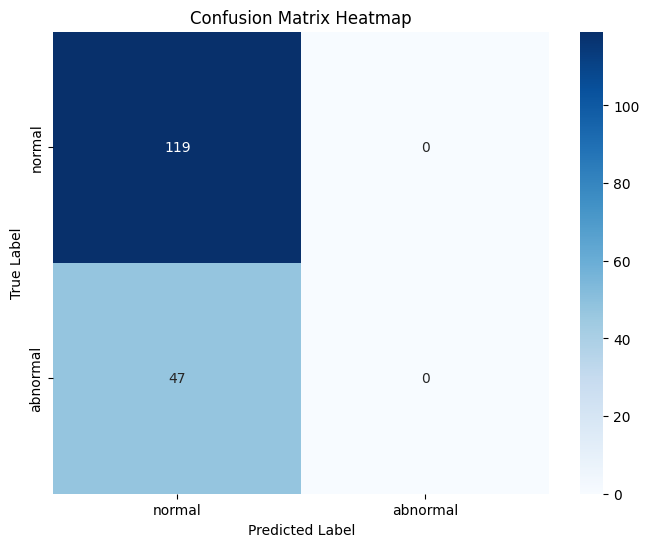

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()